
# Leeway backtracking


In [1]:
import os
os.path

from datetime import timedelta
import cmocean

import pyproj
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import opendrift
from opendrift.readers import reader_netCDF_CF_generic
from opendrift.models.leeway import Leeway

We try to find the likelihood of the origin of a found object by two different methods:
1. backwards simulation from position where object is found ('Observation')
2. forwards simulation from a uniform grid of possible initial locations, selecting the origins of particles actually hitting the observed target

We use 24 hours from the NorKyst ocean model (800m pixel size) and Arome atmospheric model (2.5km pixel size)



In [2]:
orev = Leeway(loglevel=50)
reader_arome = reader_netCDF_CF_generic.Reader(orev.test_data_folder() +
    '16Nov2015_NorKyst_z_surface/arome_subset_16Nov2015.nc')
reader_norkyst = reader_netCDF_CF_generic.Reader(orev.test_data_folder() +
    '16Nov2015_NorKyst_z_surface/norkyst800_subset_16Nov2015.nc')
orev.add_reader([reader_norkyst, reader_arome])

duration = timedelta(hours=24)
start_time = reader_norkyst.start_time
end_time = start_time + duration

object_type = 26  # 26 = Life-raft, no ballast
outfile = 'leeway.nc'
try:
    os.remove(outfile)
except:
    print("No such file")
ilon = 4.3  # Incident position
ilat = 60.6
text = [{'s': 'Observation', 'x': ilon, 'y': ilat, 'fontsize': 20, 'color': 'g', 'zorder': 1000}]
# Define domain of possible origin
#lons = np.arange(3.4, 5, .1/20)
#lats = np.arange(59.7, 60.8, .05/20)
lons = np.arange(3.4, 5, .1/2) # Much coarser CCC
lats = np.arange(59.7, 60.8, .05/2)
corners = [lons[0], lons[-1], lats[0], lats[-1]]
lons, lats = np.meshgrid(lons, lats)

ValueError: [Errno 2] No such file or directory: 'C:\\Users\\bente\\miniconda3\\envs\\opendrift\\Lib\\site-packages\\tests\\test_data\\16Nov2015_NorKyst_z_surface\\arome_subset_16Nov2015.nc'

In [3]:
lons = np.arange(3.4, 5, .1/2) # Much coarser CCC
lats = np.arange(59.7, 60.8, .05/2)
corners = [lons[0], lons[-1], lats[0], lats[-1]]
lons, lats = np.meshgrid(lons, lats)
lons

array([[3.4 , 3.45, 3.5 , ..., 4.85, 4.9 , 4.95],
       [3.4 , 3.45, 3.5 , ..., 4.85, 4.9 , 4.95],
       [3.4 , 3.45, 3.5 , ..., 4.85, 4.9 , 4.95],
       ...,
       [3.4 , 3.45, 3.5 , ..., 4.85, 4.9 , 4.95],
       [3.4 , 3.45, 3.5 , ..., 4.85, 4.9 , 4.95],
       [3.4 , 3.45, 3.5 , ..., 4.85, 4.9 , 4.95]])

Simulating first backwards for 24 hours:



16:35:59 DEBUG   opendrift.models.basemodel:615: Adding 17 config items from basemodel
16:36:00 DEBUG   opendrift.models.basemodel:615: Adding 4 config items from basemodel
16:36:00 DEBUG   opendrift.models.basemodel:615: Adding 10 config items from basemodel
16:36:00 INFO    opendrift.models.basemodel:529: OpenDriftSimulation initialised (version 1.10.7 / v1.10.6-74-g225a4d6-dirty)
16:36:00 DEBUG   opendrift.models.basemodel:615: Adding 2 config items from leeway
16:36:00 DEBUG   opendrift.models.basemodel:627:   Overwriting config item seed:jibe_probability
16:36:00 DEBUG   opendrift.export.io_netcdf:216: Importing with Xarray from leeway.nc
16:36:00 INFO    opendrift:118: Returning <class 'opendrift.models.leeway.Leeway'> object
16:36:00 INFO    opendrift.models.basemodel:4647: 	calculating for origin_marker 0...
16:36:00 DEBUG   opendrift.models.basemodel:3160: Setting up map: corners=[3.4, 4.949999999999994, 59.7, 60.77499999999994], fast=True, lscale=None
16:36:00 WARNING opendri

0.02 ALPHA


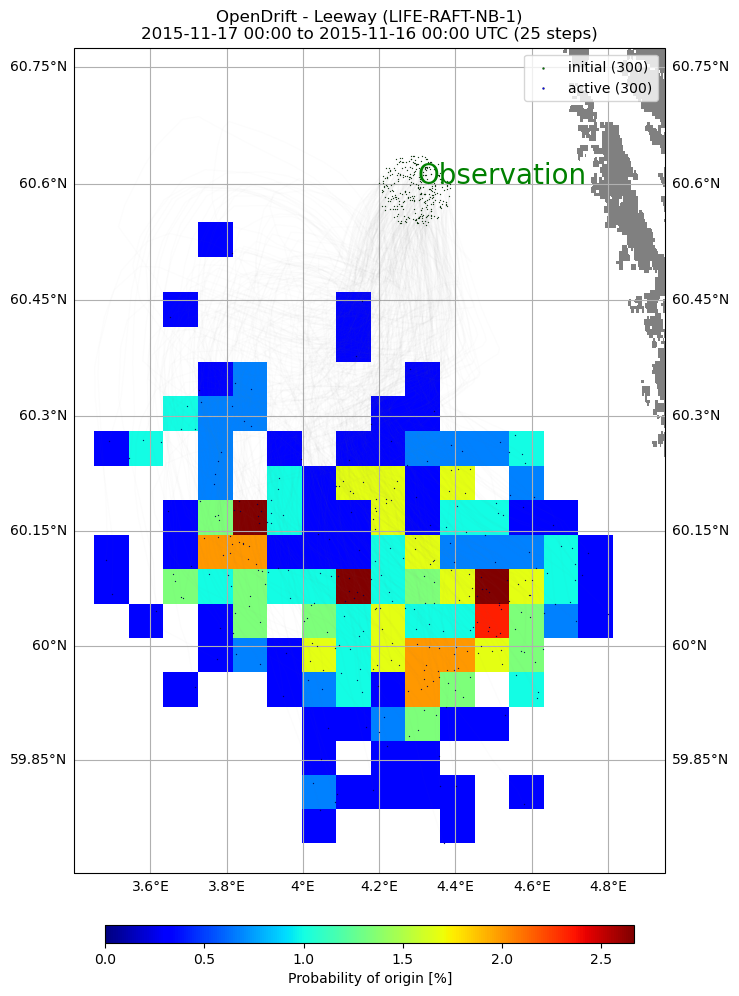

In [16]:
#o.seed_elements(lon=ilon, lat=ilat, radius=5000, radius_type='uniform', number=30000,
#                 time=end_time, object_type=object_type)
orev.seed_elements(lon=ilon, lat=ilat, radius=5000, radius_type='uniform', number=300,
                 time=end_time, object_type=object_type)
orev.run(duration=duration, time_step=-900, time_step_output=3600, outfile=outfile)
od = opendrift.open_xarray(outfile)
density_backwards = od.get_histogram(pixelsize_m=5000).isel(time=-1).isel(origin_marker=0)
density_backwards = density_backwards.where(density_backwards>0)
density_backwards = density_backwards/density_backwards.sum()*100
vmax = density_backwards.max()
orev.plot(background=density_backwards, clabel='Probability of origin [%]', text=text, corners=corners, fast=True, markersize=.5, lalpha=.02, vmin=0, vmax=vmax)
os.remove(outfile)

Try to use the "initial" locations from the reverse drift as initial locations for a forward run. 



In [35]:
lonrev, latrev = orev.get_lonlats()
loninit = np.tile(lonrev[:,-1],(10,1))
latinit = np.tile(latrev[:,-1],(10,1))

# TODO: multiply these 300 to 30000 particles randomly scattered about each of the original points with given radius
orevfwd = Leeway(loglevel=50)
orevfwd.add_reader([reader_norkyst, reader_arome])
orevfwd.seed_elements(lon=loninit, lat=latinit, radius=500.0, radius_type='gaussian', 
                 time=start_time, object_type=object_type)
orevfwd.run(duration=duration, time_step=900, time_step_output=3600, outfile=outfile)
#print(orevfwd)


16:57:27 DEBUG   opendrift.models.basemodel:615: Adding 17 config items from basemodel
16:57:27 DEBUG   opendrift.models.basemodel:615: Adding 4 config items from basemodel
16:57:27 DEBUG   opendrift.models.basemodel:615: Adding 10 config items from basemodel
16:57:27 INFO    opendrift.models.basemodel:529: OpenDriftSimulation initialised (version 1.10.7 / v1.10.6-74-g225a4d6-dirty)
16:57:27 DEBUG   opendrift.models.basemodel:615: Adding 2 config items from leeway
16:57:27 DEBUG   opendrift.models.basemodel:627:   Overwriting config item seed:jibe_probability
16:57:27 DEBUG   opendrift.export.io_netcdf:269: Importing from leeway.nc
16:57:27 DEBUG   opendrift.models.basemodel:2446: No elements to deactivate
16:57:27 DEBUG   opendrift.export.io_netcdf:367: Setting imported config: general:use_auto_landmask -> True
16:57:27 DEBUG   opendrift.export.io_netcdf:367: Setting imported config: general:coastline_action -> stranding
16:57:27 DEBUG   opendrift.export.io_netcdf:367: Setting importe

0.1 ALPHA


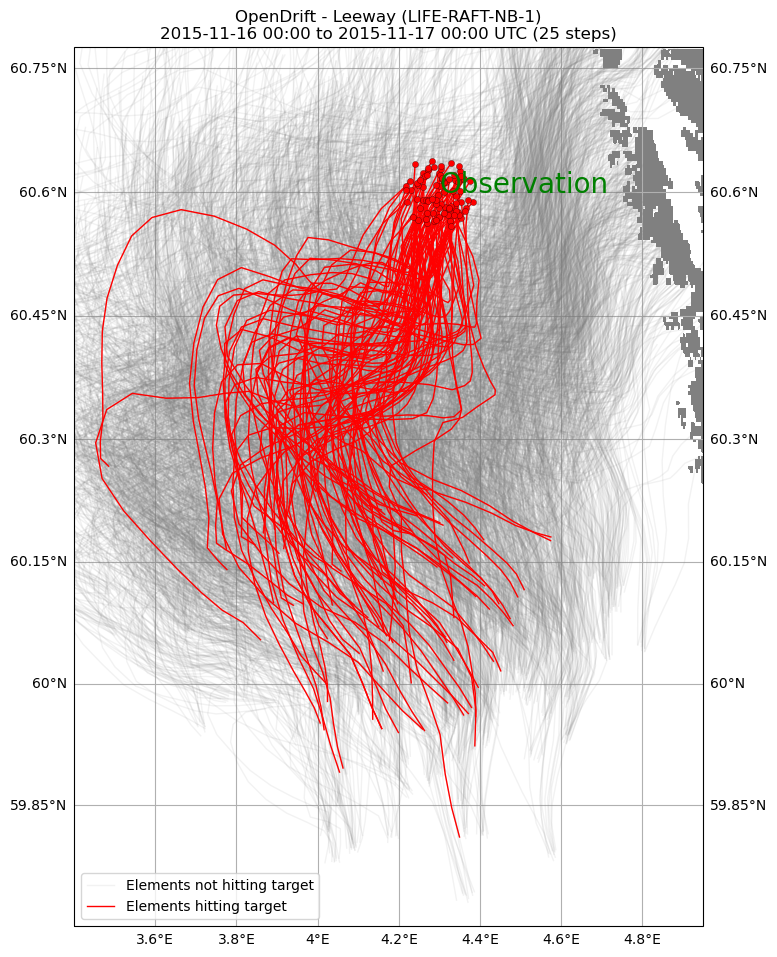

(<GeoAxes: title={'center': 'OpenDrift - Leeway (LIFE-RAFT-NB-1)\n2015-11-16 00:00 to 2015-11-17 00:00 UTC (25 steps)'}>,
 <Figure size 787.323x1100 with 1 Axes>)

In [36]:
lon, lat = orevfwd.get_lonlats()
lonend = lon[:, -1]
latend = lat[:, -1]
geod = pyproj.Geod(ellps='WGS84')
on = np.ones(lonend.shape)
dummy1, dummy2, dist2incident = geod.inv(lonend, latend, ilon*on, ilat*on)
hits = np.where(dist2incident<5000)[0]
hit_start_lons = lon[hits, 0]
hit_start_lats = lat[hits, 0]
o_hit = opendrift.open(outfile, elements=hits)

#orevfwd.animation(compare=o_hit, legend=['Elements not hitting target', 'Elements hitting target'], fast=True, corners=corners, text=text)
orevfwd.plot(compare=o_hit, legend=['Elements not hitting target', 'Elements hitting target'], show_elements=False, fast=True, corners=corners, text=text)

16:57:48 DEBUG   opendrift.models.basemodel:615: Adding 17 config items from basemodel
16:57:48 DEBUG   opendrift.models.basemodel:615: Adding 4 config items from basemodel
16:57:48 DEBUG   opendrift.models.basemodel:615: Adding 10 config items from basemodel
16:57:48 INFO    opendrift.models.basemodel:529: OpenDriftSimulation initialised (version 1.10.7 / v1.10.6-74-g225a4d6-dirty)
16:57:48 DEBUG   opendrift.models.basemodel:615: Adding 2 config items from leeway
16:57:48 DEBUG   opendrift.models.basemodel:627:   Overwriting config item seed:jibe_probability
16:57:48 DEBUG   opendrift.export.io_netcdf:216: Importing with Xarray from leeway.nc
16:57:48 INFO    opendrift:118: Returning <class 'opendrift.models.leeway.Leeway'> object
16:57:48 INFO    opendrift.models.basemodel:4647: 	calculating for origin_marker 0...
16:57:48 DEBUG   opendrift.models.basemodel:3160: Setting up map: corners=[3.4, 4.949999999999994, 59.7, 60.77499999999994], fast=True, lscale=None
16:57:48 WARNING opendri

0.02 ALPHA


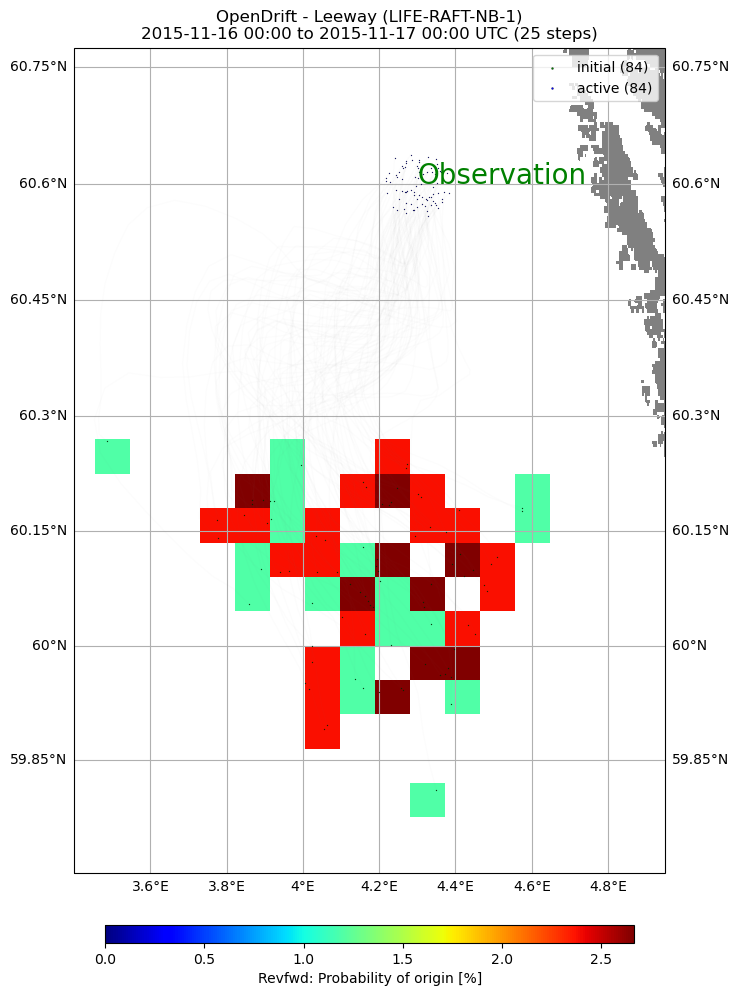

(<GeoAxes: title={'center': 'OpenDrift - Leeway (LIFE-RAFT-NB-1)\n2015-11-16 00:00 to 2015-11-17 00:00 UTC (25 steps)'}>,
 <Figure size 787.323x1100 with 2 Axes>)

In [37]:
orf = opendrift.open_xarray(outfile, elements=hits)
density_revfwd = orf.get_histogram(pixelsize_m=5000).isel(time=0).isel(origin_marker=0)
density_revfwd = density_revfwd.where(density_revfwd>0)
o_hit.plot(background=density_revfwd/density_revfwd.sum()*100, clabel='Revfwd: Probability of origin [%]', text=text, corners=corners, fast=True, markersize=.5, lalpha=.02, vmin=0, vmax=vmax)

Simulating forward, starting at a uniform grid 24 hours earlier (440 x 320 = 140800 elements at ~500m separation)




In [9]:
ofwd = Leeway(loglevel=50)
ofwd.add_reader([reader_norkyst, reader_arome])
ofwd.seed_elements(lon=lons, lat=lats, radius=0,
                 time=start_time, object_type=object_type)
try:
    os.remove(outfile)
except:
    print("No such file")
ofwd.run(duration=duration, time_step=900, time_step_output=3600, outfile=outfile)
#print(ofwd)

Finding the elements actually hitting the target (within 5 km) after 24 hours:



In [11]:
lon, lat = ofwd.get_lonlats()
lonend = lon[:, -1]
latend = lat[:, -1]
geod = pyproj.Geod(ellps='WGS84')
on = np.ones(lonend.shape)
dummy1, dummy2, dist2incident = geod.inv(lonend, latend, ilon*on, ilat*on)
hits = np.where(dist2incident<5000)[0]
hit_start_lons = lon[hits, 0]
hit_start_lats = lat[hits, 0]
o_hit = opendrift.open(outfile, elements=hits)

#ofwd.animation(compare=o_hit, legend=['Elements not hitting target', 'Elements hitting target'], fast=True, corners=corners, text=text)

11:56:34 DEBUG   opendrift.models.basemodel:615: Adding 17 config items from basemodel
11:56:34 DEBUG   opendrift.models.basemodel:615: Adding 4 config items from basemodel
11:56:34 DEBUG   opendrift.models.basemodel:615: Adding 10 config items from basemodel
11:56:34 INFO    opendrift.models.basemodel:529: OpenDriftSimulation initialised (version 1.10.7 / v1.10.6-74-g225a4d6-dirty)
11:56:34 DEBUG   opendrift.models.basemodel:615: Adding 2 config items from leeway
11:56:34 DEBUG   opendrift.models.basemodel:627:   Overwriting config item seed:jibe_probability
11:56:34 DEBUG   opendrift.export.io_netcdf:269: Importing from leeway.nc
11:56:34 DEBUG   opendrift.models.basemodel:2446: No elements to deactivate
11:56:34 DEBUG   opendrift.export.io_netcdf:367: Setting imported config: general:use_auto_landmask -> True
11:56:34 DEBUG   opendrift.export.io_netcdf:367: Setting imported config: general:coastline_action -> stranding
11:56:34 DEBUG   opendrift.export.io_netcdf:367: Setting importe

<img src="file://gallery/animations/example_leeway_backtrack_0.gif">



11:56:39 DEBUG   opendrift.models.basemodel:3160: Setting up map: corners=[3.4, 4.949999999999994, 59.7, 60.77499999999994], fast=True, lscale=None
11:56:39 WARNING opendrift.models.basemodel:3206: Plotting fast. This will make your plots less accurate.


0.27358193535541725 ALPHA


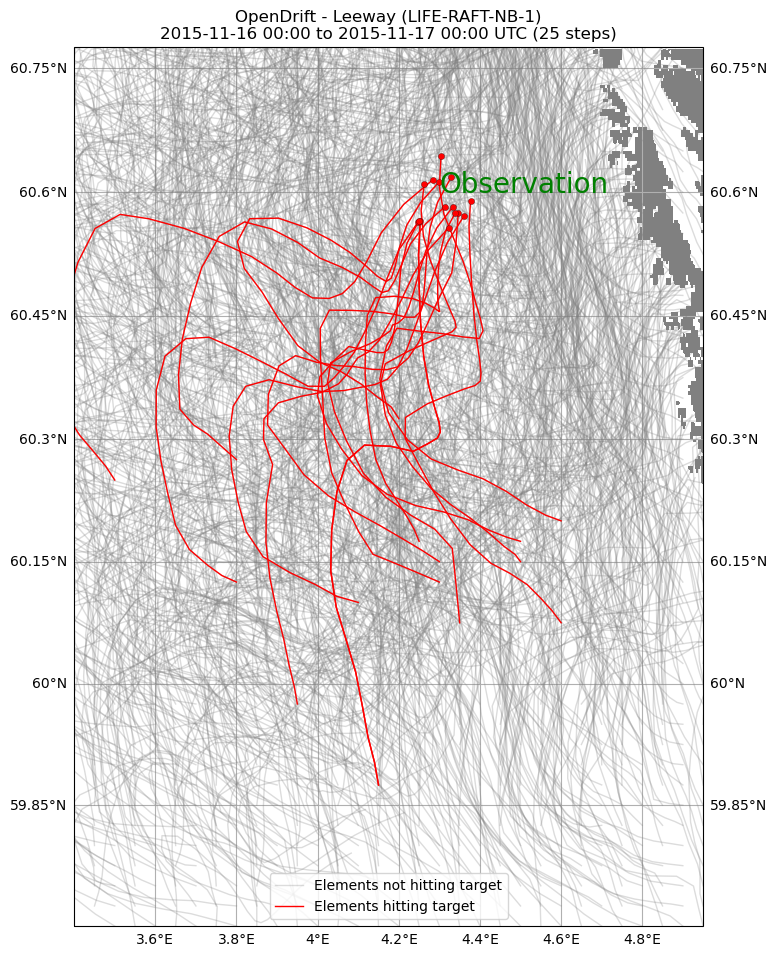

(<GeoAxes: title={'center': 'OpenDrift - Leeway (LIFE-RAFT-NB-1)\n2015-11-16 00:00 to 2015-11-17 00:00 UTC (25 steps)'}>,
 <Figure size 787.323x1100 with 1 Axes>)

In [12]:
ofwd.plot(compare=o_hit, legend=['Elements not hitting target', 'Elements hitting target'], show_elements=False, fast=True, corners=corners, text=text)

Plot the initial density of elements that actually hit the target after 24 hours. To be compared with the density figure from backwards simulation (see top)



11:56:51 DEBUG   opendrift.models.basemodel:615: Adding 17 config items from basemodel
11:56:51 DEBUG   opendrift.models.basemodel:615: Adding 4 config items from basemodel
11:56:51 DEBUG   opendrift.models.basemodel:615: Adding 10 config items from basemodel
11:56:51 INFO    opendrift.models.basemodel:529: OpenDriftSimulation initialised (version 1.10.7 / v1.10.6-74-g225a4d6-dirty)
11:56:51 DEBUG   opendrift.models.basemodel:615: Adding 2 config items from leeway
11:56:51 DEBUG   opendrift.models.basemodel:627:   Overwriting config item seed:jibe_probability
11:56:51 DEBUG   opendrift.export.io_netcdf:216: Importing with Xarray from leeway.nc
11:56:52 INFO    opendrift:118: Returning <class 'opendrift.models.leeway.Leeway'> object
11:56:52 INFO    opendrift.models.basemodel:4647: 	calculating for origin_marker 0...
11:56:52 DEBUG   opendrift.models.basemodel:3160: Setting up map: corners=[3.4, 4.949999999999994, 59.7, 60.77499999999994], fast=True, lscale=None
11:56:52 WARNING opendri

0.02 ALPHA


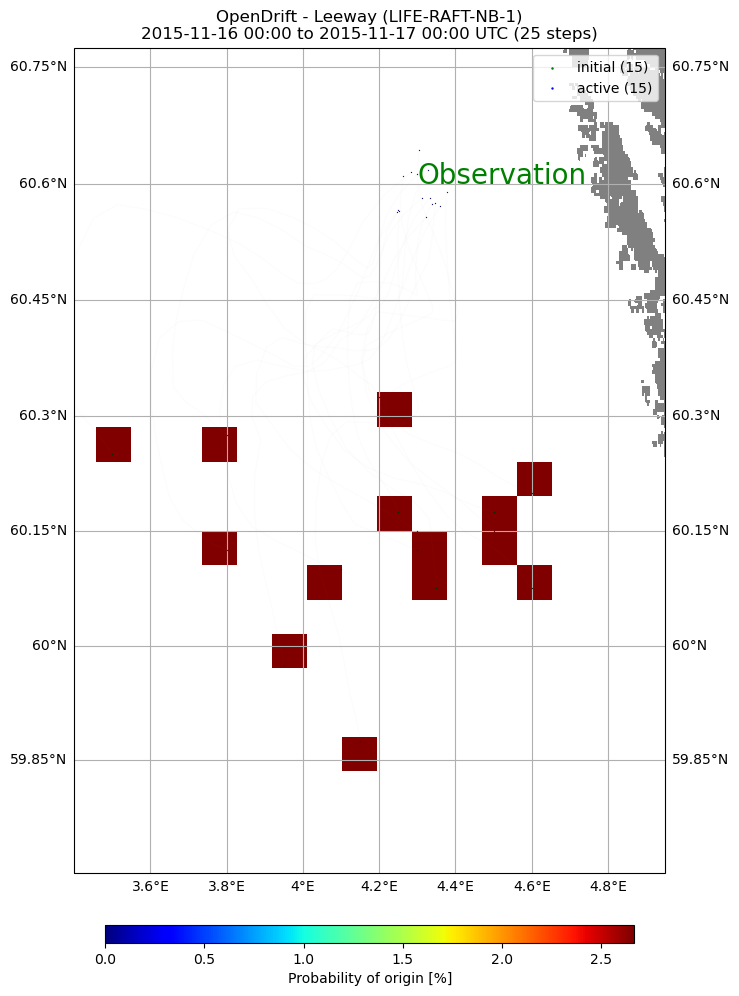

(<GeoAxes: title={'center': 'OpenDrift - Leeway (LIFE-RAFT-NB-1)\n2015-11-16 00:00 to 2015-11-17 00:00 UTC (25 steps)'}>,
 <Figure size 787.323x1100 with 2 Axes>)

In [13]:
of = opendrift.open_xarray(outfile, elements=hits)
density_forwards = of.get_histogram(pixelsize_m=5000).isel(time=0).isel(origin_marker=0)
density_forwards = density_forwards.where(density_forwards>0)
o_hit.plot(background=density_forwards/density_forwards.sum()*100, clabel='Probability of origin [%]', text=text, corners=corners, fast=True, markersize=.5, lalpha=.02, vmin=0, vmax=vmax)